In [1]:
!pip install pyphi
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import pickle
import math
from operator import add
import torch
import torch.nn as nn
import pyphi
np.set_printoptions(threshold=sys.maxsize)


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [2]:
def make_rule(integer):
    binary = str(bin(integer)[2:])
    
    if len(binary) < 8:
        binary = binary.zfill(8)
    
    def rule_function(array):
        row1 = array
        next_row = array.copy()
        for x in range(1, len(row1)-1):
                
            # Given cell state is "off", then update given the neighbors like - 
            if row1[x] == 0:
                if (row1[x-1] == 0) and (row1[x+1] == 0):
                    next_row[x] = int(binary[7])

                if (row1[x-1] == 0) and (row1[x+1] == 1):
                    next_row[x] = int(binary[6])

                if (row1[x-1] == 1) and (row1[x+1] == 0):
                    next_row[x] = int(binary[3])

                if (row1[x-1] == 1) and (row1[x+1] == 1):
                    next_row[x] = int(binary[2])

            # Given cell state is "on", then update given the neighbors like -   
            else:
                if (row1[x-1] == 0) and (row1[x+1] == 0):
                    next_row[x] = int(binary[5])

                if (row1[x-1] == 0) and (row1[x+1] == 1):
                    next_row[x] = int(binary[4])

                if (row1[x-1] == 1) and (row1[x+1] == 0):
                    next_row[x] = int(binary[1])

                if (row1[x-1] == 1) and (row1[x+1] == 1):
                    next_row[x] = int(binary[0])
                    
            next_row[0] = next_row[1]
            next_row[len(row1)-1] = next_row[len(row1)-2]

        return np.array(next_row)

    return rule_function

In [3]:
# NOTE: 'timestep' variable used to denote the timestep in which the perturbation will occur, and 'n' is the number of...
#... iterations performed by the ECA. 

def apply_rule(rule_function, n, perturbation_boolean, timestep, cell):
    ini_state = initial_state(2*n + 1)
    rv = []
    rv.append(ini_state)
    if perturbation_boolean == True:
        for i in range(1, n):
            if i == timestep:
                timestep_update = rule_function(ini_state)
                if timestep_update[cell] == 0:
                    timestep_update[cell] = 1
                else:
                    timestep_update[cell] = 0
                    
                rv.append(timestep_update)
                ini_state = timestep_update
                
            else:
                timestep_update = rule_function(ini_state)
                rv.append(timestep_update)
                ini_state = timestep_update
          
    else:
        for i in range(1, n):
            timestep_update = rule_function(ini_state)
            rv.append(timestep_update)
            ini_state = timestep_update
        
    return np.array(rv)

In [4]:
def initial_state(width):
    initial = np.zeros((1, width), dtype=int)
    if width % 2 == 0:
        initial = np.insert(initial, int(width / 2), values=0, axis=1)
        initial[0, int(width / 2)] = 1
        return initial[0]
    else:
        initial[0, int(width / 2)] = 1
        return initial[0]

In [5]:
def TPM(rule_function, number_of_cells):
    
    maximum_range = 2**(number_of_cells+2)
    TPM_matrix = []
    
    for i in range(maximum_range):
        
        binary = bin(i)[2:]
        binary = binary.zfill(number_of_cells+2)
        
        state_iter_array = [int(i) for i in str(binary)]
        next_timestep = rule_function(state_iter_array)
        
        
        TPM_matrix.append(next_timestep)    
        
    return TPM_matrix

In [6]:
n = 3
m = n+2
cm = []
phi_averages_list = []
concepts_averages_list = []

for i in range(m):
    l_cm = np.zeros(m)
    if i > 0 and i < m-1:
        l_cm[i] = 1
        l_cm[i-1] = 1
        l_cm[i+1] = 1
    cm.append(l_cm)

subsystem_list = []

for i in range(n):
    subsystem_list.append(i+1)
    
print(subsystem_list)

labels = ('$\gamma$', 'A', 'B', 'C', '$\delta$')

[1, 2, 3]


In [7]:
with open("Saved_Concepts_List_7", "rb") as pf:   # Unpickling
    concepts_averages_list = pickle.load(pf)

with open("Saved_Phi_List_7", "rb") as pf:   # Unpickling
    phi_averages_list = pickle.load(pf)
    
print(len(concepts_averages_list))
print(len(phi_averages_list))

191
191


In [8]:
for i in range(191, 210):
  print('**********************************')
  print(i)
  rule_30 = make_rule(i)
  TPM_matrix = TPM(rule_30, n)
  network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)
  counter = 0
  phi_sum = 0
  concepts_sum = 0  

  for j in range(2**5):
    blah = []
    binary = str(bin(j)[2:])
    if len(binary) < 5:
      binary = binary.zfill(5)

    for char in binary:
      blah.append(int(char))

    state = tuple(blah)

    try:
      subsystem = pyphi.Subsystem(network, state, subsystem_list)
      value = pyphi.compute.phi(subsystem)
      sia = pyphi.compute.sia(subsystem)
      concepts = len(sia.ces)
      if value != 0:
        phi_sum += value
        concepts_sum += concepts
        counter += 1
    except:
      continue
  if counter == 0:
    phi_averages_list.append(0)
    concepts_averages_list.append(0)
  else:
    phi_averages_list.append(phi_sum/counter)
    concepts_averages_list.append(concepts_sum/counter)

  if i%5 == 0:
    with open("Saved_Phi_List_7", "wb") as pf:
      pickle.dump(phi_averages_list, pf)
      
    with open("Saved_Concepts_List_7", "wb") as fp:
      pickle.dump(concepts_averages_list, fp)

**********************************
191


**********************************
192


**********************************
193


**********************************
194


**********************************
195


**********************************
196


**********************************
197


**********************************
198


**********************************
199


**********************************
200


**********************************
201


**********************************
202


**********************************
203


**********************************
204


**********************************
205


**********************************
206


**********************************
207


**********************************
208


**********************************
209


In [9]:
for i in range(210, 240):
  print('**********************************')
  print(i)
  rule_30 = make_rule(i)
  TPM_matrix = TPM(rule_30, n)
  network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)
  counter = 0
  phi_sum = 0
  concepts_sum = 0  

  for j in range(2**5):
    blah = []
    binary = str(bin(j)[2:])
    if len(binary) < 5:
      binary = binary.zfill(5)

    for char in binary:
      blah.append(int(char))

    state = tuple(blah)

    try:
      subsystem = pyphi.Subsystem(network, state, subsystem_list)
      value = pyphi.compute.phi(subsystem)
      sia = pyphi.compute.sia(subsystem)
      concepts = len(sia.ces)
      if value != 0:
        phi_sum += value
        concepts_sum += concepts
        counter += 1
    except:
      continue
  if counter == 0:
    phi_averages_list.append(0)
    concepts_averages_list.append(0)
  else:
    phi_averages_list.append(phi_sum/counter)
    concepts_averages_list.append(concepts_sum/counter)

  if i%5 == 0:
    with open("Saved_Phi_List_8", "wb") as pf:
      pickle.dump(phi_averages_list, pf)
      
    with open("Saved_Concepts_List_8", "wb") as fp:
      pickle.dump(concepts_averages_list, fp)

**********************************
210


**********************************
211


**********************************
212


**********************************
213


**********************************
214


**********************************
215


**********************************
216


**********************************
217


**********************************
218


**********************************
219


**********************************
220


**********************************
221


**********************************
222


**********************************
223


**********************************
224


**********************************
225


**********************************
226


**********************************
227


**********************************
228


**********************************
229


**********************************
230


**********************************
231


**********************************
232


**********************************
233


**********************************
234


**********************************
235


**********************************
236


**********************************
237


**********************************
238


**********************************
239


In [10]:
for i in range(240, 256):
  print('**********************************')
  print(i)
  rule_30 = make_rule(i)
  TPM_matrix = TPM(rule_30, n)
  network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)
  counter = 0
  phi_sum = 0
  concepts_sum = 0  

  for j in range(2**5):
    blah = []
    binary = str(bin(j)[2:])
    if len(binary) < 5:
      binary = binary.zfill(5)

    for char in binary:
      blah.append(int(char))

    state = tuple(blah)

    try:
      subsystem = pyphi.Subsystem(network, state, subsystem_list)
      value = pyphi.compute.phi(subsystem)
      sia = pyphi.compute.sia(subsystem)
      concepts = len(sia.ces)
      if value != 0:
        phi_sum += value
        concepts_sum += concepts
        counter += 1
    except:
      continue
  if counter == 0:
    phi_averages_list.append(0)
    concepts_averages_list.append(0)
  else:
    phi_averages_list.append(phi_sum/counter)
    concepts_averages_list.append(concepts_sum/counter)

  if i%5 == 0:
    with open("Saved_Phi_List_9", "wb") as pf:
      pickle.dump(phi_averages_list, pf)
      
    with open("Saved_Concepts_List_9", "wb") as fp:
      pickle.dump(concepts_averages_list, fp)

**********************************
240


**********************************
241


**********************************
242


**********************************
243


**********************************
244


**********************************
245


**********************************
246


**********************************
247


**********************************
248


**********************************
249


**********************************
250


**********************************
251


**********************************
252


**********************************
253


**********************************
254


**********************************
255


In [14]:
print(len(concepts_averages_list))
print(len(phi_averages_list))

256
256


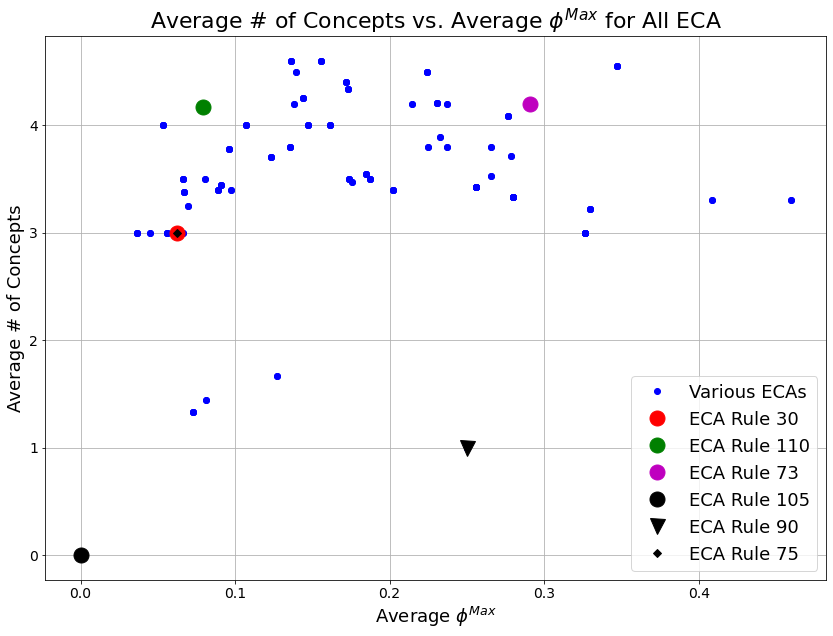

In [134]:
concepts_averages_list = concepts_averages_list[0:256]
phi_averages_list = phi_averages_list[0:256]


plt.figure(figsize=(14,10))
plt.ylabel('Average # of Concepts', fontsize = 18)
plt.xlabel('Average $\phi^{Max}$', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Average # of Concepts vs. Average $\phi^{Max}$ for All ECA', fontsize = 22)
plt.plot(phi_averages_list, concepts_averages_list, 'bo', label = "Various ECAs")
plt.plot(phi_averages_list[30], concepts_averages_list[30], 'ro', markersize = 15, label = 'ECA Rule 30')
plt.plot(phi_averages_list[110], concepts_averages_list[110], 'go', markersize = 15, label = 'ECA Rule 110')
plt.plot(phi_averages_list[73], concepts_averages_list[73], 'mo', markersize = 15, label = 'ECA Rule 73')
plt.plot(phi_averages_list[105], concepts_averages_list[105], 'ko', markersize = 15, label = 'ECA Rule 105')
plt.plot(phi_averages_list[90], concepts_averages_list[90], 'kv', markersize = 15, label = 'ECA Rule 90')
plt.plot(phi_averages_list[75], concepts_averages_list[75], 'kD', markersize = 6, label = 'ECA Rule 75')
plt.legend(fontsize = 18)
plt.grid()

In [117]:
def make_rule_V2(integer):
    binary = str(bin(integer)[2:])
    
    if len(binary) < 32:
        binary = binary.zfill(32)
    
    def rule_function_V2(array):
        row1 = array
        next_row = array.copy()
        for x in range(2, len(row1)-2):
                
            # Given cell state is "off", then update given the neighbors like - 
            if row1[x] == 0:
                
                if (row1[x-2] == 0) and (row1[x-1] == 0) and (row1[x+1] == 0) and (row1[x+2] == 0):
                    next_row[x] = int(binary[0])
                if (row1[x-2] == 1) and (row1[x-1] == 1) and (row1[x+1] == 1) and (row1[x+2] == 1):
                    next_row[x] = int(binary[1])
    
                    
                    
                if (row1[x-2] == 0) and (row1[x-1] == 0) and (row1[x+1] == 0) and (row1[x+2] == 1):
                    next_row[x] = int(binary[2])
                
                if (row1[x-2] == 0) and (row1[x-1] == 0) and (row1[x+1] == 1) and (row1[x+2] == 0):
                    next_row[x] = int(binary[3])
                
                if (row1[x-2] == 0) and (row1[x-1] == 1) and (row1[x+1] == 0) and (row1[x+2] == 0):
                    next_row[x] = int(binary[4])
                    
                if (row1[x-2] == 1) and (row1[x-1] == 0) and (row1[x+1] == 0) and (row1[x+2] == 0):
                    next_row[x] = int(binary[5])
                    
                
                
                if (row1[x-2] == 1) and (row1[x-1] == 0) and (row1[x+1] == 0) and (row1[x+2] == 1):
                    next_row[x] = int(binary[6])
                    
                if (row1[x-2] == 1) and (row1[x-1] == 0) and (row1[x+1] == 1) and (row1[x+2] == 0):
                    next_row[x] = int(binary[7])

                if (row1[x-2] == 0) and (row1[x-1] == 1) and (row1[x+1] == 0) and (row1[x+2] == 1):
                    next_row[x] = int(binary[8])
                    
                if (row1[x-2] == 0) and (row1[x-1] == 1) and (row1[x+1] == 1) and (row1[x+2] == 0):
                    next_row[x] = int(binary[9])
                    
                if (row1[x-2] == 1) and (row1[x-1] == 1) and (row1[x+1] == 0) and (row1[x+2] == 0):
                    next_row[x] = int(binary[10])
                    
                if (row1[x-2] == 0) and (row1[x-1] == 0) and (row1[x+1] == 1) and (row1[x+2] == 1):
                    next_row[x] = int(binary[11])
                    
                    
                    
                if (row1[x-2] == 1) and (row1[x-1] == 1) and (row1[x+1] == 1) and (row1[x+2] == 0):
                    next_row[x] = int(binary[12])
                
                if (row1[x-2] == 1) and (row1[x-1] == 1) and (row1[x+1] == 0) and (row1[x+2] == 1):
                    next_row[x] = int(binary[13])
                
                if (row1[x-2] == 1) and (row1[x-1] == 0) and (row1[x+1] == 1) and (row1[x+2] == 1):
                    next_row[x] = int(binary[14])
                    
                if (row1[x-2] == 0) and (row1[x-1] == 1) and (row1[x+1] == 1) and (row1[x+2] == 1):
                    next_row[x] = int(binary[15])
            

            # Given cell state is "on", then update given the neighbors like -   
            else:
                
                if (row1[x-2] == 0) and (row1[x-1] == 0) and (row1[x+1] == 0) and (row1[x+2] == 0):
                    next_row[x] = int(binary[16])
                if (row1[x-2] == 1) and (row1[x-1] == 1) and (row1[x+1] == 1) and (row1[x+2] == 1):
                    next_row[x] = int(binary[17])
    
                    
                    
                if (row1[x-2] == 0) and (row1[x-1] == 0) and (row1[x+1] == 0) and (row1[x+2] == 1):
                    next_row[x] = int(binary[18])
                
                if (row1[x-2] == 0) and (row1[x-1] == 0) and (row1[x+1] == 1) and (row1[x+2] == 0):
                    next_row[x] = int(binary[19])
                
                if (row1[x-2] == 0) and (row1[x-1] == 1) and (row1[x+1] == 0) and (row1[x+2] == 0):
                    next_row[x] = int(binary[20])
                    
                if (row1[x-2] == 1) and (row1[x-1] == 0) and (row1[x+1] == 0) and (row1[x+2] == 0):
                    next_row[x] = int(binary[21])
                    
                
                
                if (row1[x-2] == 1) and (row1[x-1] == 0) and (row1[x+1] == 0) and (row1[x+2] == 1):
                    next_row[x] = int(binary[22])
                    
                if (row1[x-2] == 1) and (row1[x-1] == 0) and (row1[x+1] == 1) and (row1[x+2] == 0):
                    next_row[x] = int(binary[23])

                if (row1[x-2] == 0) and (row1[x-1] == 1) and (row1[x+1] == 0) and (row1[x+2] == 1):
                    next_row[x] = int(binary[24])
                    
                if (row1[x-2] == 0) and (row1[x-1] == 1) and (row1[x+1] == 1) and (row1[x+2] == 0):
                    next_row[x] = int(binary[25])
                    
                if (row1[x-2] == 1) and (row1[x-1] == 1) and (row1[x+1] == 0) and (row1[x+2] == 0):
                    next_row[x] = int(binary[26])
                    
                if (row1[x-2] == 0) and (row1[x-1] == 0) and (row1[x+1] == 1) and (row1[x+2] == 1):
                    next_row[x] = int(binary[27])
                    
                    
                    
                if (row1[x-2] == 1) and (row1[x-1] == 1) and (row1[x+1] == 1) and (row1[x+2] == 0):
                    next_row[x] = int(binary[28])
                
                if (row1[x-2] == 1) and (row1[x-1] == 1) and (row1[x+1] == 0) and (row1[x+2] == 1):
                    next_row[x] = int(binary[29])
                
                if (row1[x-2] == 1) and (row1[x-1] == 0) and (row1[x+1] == 1) and (row1[x+2] == 1):
                    next_row[x] = int(binary[30])
                    
                if (row1[x-2] == 0) and (row1[x-1] == 1) and (row1[x+1] == 1) and (row1[x+2] == 1):
                    next_row[x] = int(binary[31])

                    
            next_row[0] = next_row[2]
            next_row[1] = next_row[2]
            next_row[len(row1)-1] = next_row[len(row1)-3]
            next_row[len(row1)-2] = next_row[len(row1)-3]
            

        return np.array(next_row)

    return rule_function_V2

Text(0.5, 0, 'Cell Index')

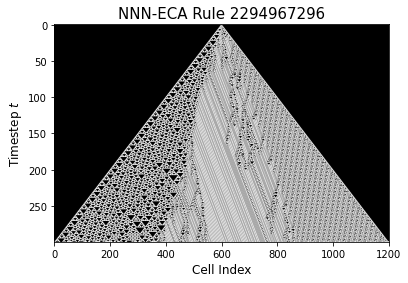

In [118]:
rule_function_check = make_rule_V2(2294967296)

plt.imshow(apply_rule_V2(rule_function_check, 300, False, 0, 0), cmap='binary', aspect='auto')
plt.title('NNN-ECA Rule 2294967296', fontsize=15)
plt.ylabel("Timestep $t$", fontsize=12)
plt.xlabel("Cell Index", fontsize=12)

In [119]:
def TPM_V2(rule_function, number_of_cells):
    
    maximum_range = 2**(number_of_cells+2)
    TPM_matrix = []
    
    for i in range(maximum_range):
        
        binary = bin(i)[2:]
        binary = binary.zfill(number_of_cells+2)
        
        state_iter_array = [int(i) for i in str(binary)]
        next_timestep = rule_function(state_iter_array)
        
        
        TPM_matrix.append(next_timestep)    
        
    return TPM_matrix

In [120]:
n = 5
rule_30 = make_rule_V2(2294967296)
TPM_matrix = TPM_V2(rule_30, n)

m = n+2
cm = []

for i in range(m):
    
    l_cm = np.zeros(m)
    
    if i > 1 and i < m-2:
        
        l_cm[i] = 1
        l_cm[i-1] = 1
        l_cm[i-2] = 1
        l_cm[i+1] = 1
        l_cm[i+2] = 1
        
    cm.append(l_cm)

print(cm)

subsystem_list = []

for i in range(2, n):
    subsystem_list.append(i)
    
print(subsystem_list)

labels = ('$\gamma$', '$theta$', 'A', 'B', 'C', '$eta$', '$\delta$')

network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)

[array([0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 0., 0.]), array([0., 1., 1., 1., 1., 1., 0.]), array([0., 0., 1., 1., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0.])]
[2, 3, 4]


In [121]:

TPM_matrix = TPM_V2(rule_30, n)
network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)
counter = 0
phi_sum = 0
concepts_sum = 0  

for j in range(2**7):
  blah = []
  binary = str(bin(j)[2:])
  if len(binary) < 7:
    binary = binary.zfill(7)

  for char in binary:
    blah.append(int(char))

  state = tuple(blah)

  try:
    subsystem = pyphi.Subsystem(network, state, subsystem_list)
    value = pyphi.compute.phi(subsystem)
    sia = pyphi.compute.sia(subsystem)
    concepts = len(sia.ces)
    if value != 0:
      phi_sum += value
      concepts_sum += concepts
      counter += 1
  except:
    continue
if counter == 0:
  phi_averages_list.append(0)
  concepts_averages_list.append(0)
else:
  phi_averages_list.append(phi_sum/counter)
  concepts_averages_list.append(concepts_sum/counter)

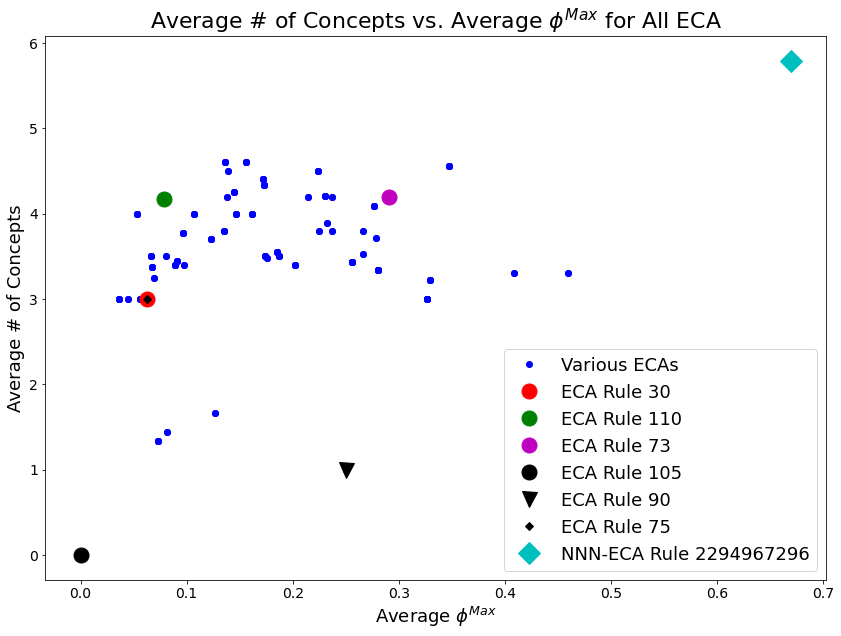

In [125]:
plt.figure(figsize=(14,10))
plt.ylabel('Average # of Concepts', fontsize = 18)
plt.xlabel('Average $\phi^{Max}$', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Average # of Concepts vs. Average $\phi^{Max}$ for All ECA', fontsize = 22)
plt.plot(phi_averages_list, concepts_averages_list, 'bo', label = "Various ECAs")
plt.plot(phi_averages_list[30], concepts_averages_list[30], 'ro', markersize = 15, label = 'ECA Rule 30')
plt.plot(phi_averages_list[110], concepts_averages_list[110], 'go', markersize = 15, label = 'ECA Rule 110')
plt.plot(phi_averages_list[73], concepts_averages_list[73], 'mo', markersize = 15, label = 'ECA Rule 73')
plt.plot(phi_averages_list[105], concepts_averages_list[105], 'ko', markersize = 15, label = 'ECA Rule 105')
plt.plot(phi_averages_list[90], concepts_averages_list[90], 'kv', markersize = 15, label = 'ECA Rule 90')
plt.plot(phi_averages_list[75], concepts_averages_list[75], 'kD', markersize = 6, label = 'ECA Rule 75')
plt.plot(phi_averages_list[-1], concepts_averages_list[-1], 'cD', markersize = 15, label = 'NNN-ECA Rule 2294967296')
plt.legend(fontsize = 18)

In [126]:
n = 5
rule_30 = make_rule_V2(331267296)
TPM_matrix = TPM_V2(rule_30, n)

m = n+2
cm = []

for i in range(m):
    
    l_cm = np.zeros(m)
    
    if i > 1 and i < m-2:
        
        l_cm[i] = 1
        l_cm[i-1] = 1
        l_cm[i-2] = 1
        l_cm[i+1] = 1
        l_cm[i+2] = 1
        
    cm.append(l_cm)

print(cm)

subsystem_list = []

for i in range(2, n):
    subsystem_list.append(i)
    
print(subsystem_list)

labels = ('$\gamma$', '$theta$', 'A', 'B', 'C', '$eta$', '$\delta$')

network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)

[array([0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 0., 0.]), array([0., 1., 1., 1., 1., 1., 0.]), array([0., 0., 1., 1., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0.])]
[2, 3, 4]


In [127]:

TPM_matrix = TPM_V2(rule_30, n)
network = pyphi.Network(TPM_matrix, cm=cm, node_labels=labels)
counter = 0
phi_sum = 0
concepts_sum = 0  

for j in range(2**7):
  blah = []
  binary = str(bin(j)[2:])
  if len(binary) < 7:
    binary = binary.zfill(7)

  for char in binary:
    blah.append(int(char))

  state = tuple(blah)

  try:
    subsystem = pyphi.Subsystem(network, state, subsystem_list)
    value = pyphi.compute.phi(subsystem)
    sia = pyphi.compute.sia(subsystem)
    concepts = len(sia.ces)
    if value != 0:
      phi_sum += value
      concepts_sum += concepts
      counter += 1
  except:
    continue
if counter == 0:
  phi_averages_list.append(0)
  concepts_averages_list.append(0)
else:
  phi_averages_list.append(phi_sum/counter)
  concepts_averages_list.append(concepts_sum/counter)

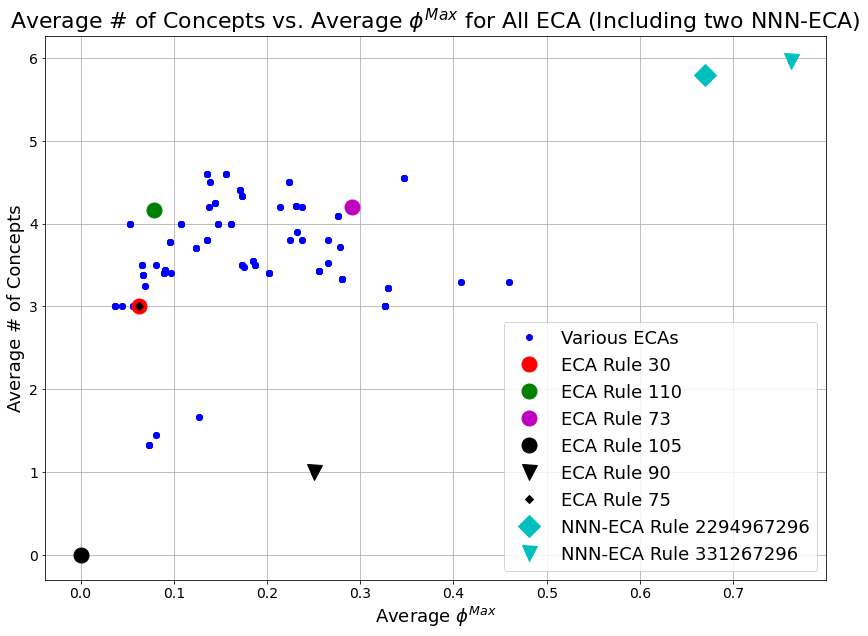

In [131]:
plt.figure(figsize=(14,10))
plt.ylabel('Average # of Concepts', fontsize = 18)
plt.xlabel('Average $\phi^{Max}$', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Average # of Concepts vs. Average $\phi^{Max}$ for All ECA (Including two NNN-ECA)', fontsize = 22)
plt.plot(phi_averages_list, concepts_averages_list, 'bo', label = "Various ECAs")
plt.plot(phi_averages_list[30], concepts_averages_list[30], 'ro', markersize = 15, label = 'ECA Rule 30')
plt.plot(phi_averages_list[110], concepts_averages_list[110], 'go', markersize = 15, label = 'ECA Rule 110')
plt.plot(phi_averages_list[73], concepts_averages_list[73], 'mo', markersize = 15, label = 'ECA Rule 73')
plt.plot(phi_averages_list[105], concepts_averages_list[105], 'ko', markersize = 15, label = 'ECA Rule 105')
plt.plot(phi_averages_list[90], concepts_averages_list[90], 'kv', markersize = 15, label = 'ECA Rule 90')
plt.plot(phi_averages_list[75], concepts_averages_list[75], 'kD', markersize = 6, label = 'ECA Rule 75')
plt.plot(phi_averages_list[-2], concepts_averages_list[-2], 'cD', markersize = 15, label = 'NNN-ECA Rule 2294967296')
plt.plot(phi_averages_list[-1], concepts_averages_list[-1], 'cv', markersize = 15, label = 'NNN-ECA Rule 331267296')
plt.legend(fontsize = 18)
plt.grid()